In [1]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence, Union
import lib
from sklearn.cluster import KMeans
import sklearn
import optax
from tqdm import tqdm

In [12]:
time_delay_dim = 10
time_delay = 5
time_range = (0, 1200, 0.02)
n_centers = 500

In [3]:
n_sins = 100
np.random.seed(2308)
periods = np.random.uniform(5, 50, n_sins)
coeffs = np.random.uniform(0, 1, n_sins)
phases = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus = lib.sinusoidals_stimulus(time_range, amplitude=30, periods=periods, coeffs=coeffs, phases=phases)

training_neuron = lib.single_neuron_odeint(stimulus, [0, 0, 0, 0])
training_neuron.generate_sol()

In [4]:
drop_first_n_points = 5000
training_neuron.sol = training_neuron.sol[drop_first_n_points:]
stimulus.stimulus_list = stimulus.stimulus_list[drop_first_n_points:]

Text(0, 0.5, 'V(t) exact')

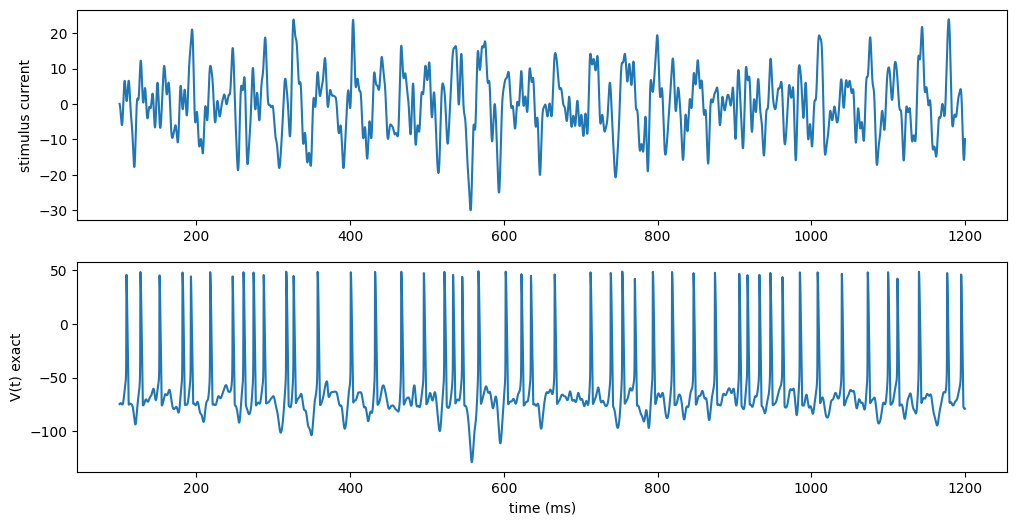

In [5]:
fig, axes = plt.subplots(2, 1,  figsize=(12, 6))

axes[0].plot(np.arange(*time_range)[drop_first_n_points:], stimulus.stimulus_list)
axes[0].set_ylabel("stimulus current")
axes[1].plot(np.arange(*time_range)[drop_first_n_points:], training_neuron.sol[:, 0])
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("V(t) exact")

In [13]:
# get points in time delay coordinate and k-means centers
points_time_delay = np.array([np.roll(training_neuron.sol[:, 0], -i*time_delay) for i in range(time_delay_dim)]).T
points_time_delay = points_time_delay[: -time_delay*(time_delay_dim-1)]
kmeans = KMeans(n_clusters=n_centers, random_state=0, n_init="auto").fit(points_time_delay)

In [14]:
# search for sigma
n_neighbors = 8
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm="ball_tree").fit(kmeans.cluster_centers_)
distances, _ = nbrs.kneighbors(kmeans.cluster_centers_)
sigma = distances[:, -1]

In [15]:
class rbf_model_plus_ann(nn.Module):
    time_delay_dim: int
    R: Union[Sequence[float], float]
    centers: Sequence[float]
    weights: Sequence[float]

    def setup(self) -> None:
        self.layer1 = nn.Dense(features=10)
        self.layer11 = nn.Dense(features=10)
        self.layer2 = nn.Dense(features=1, kernel_init=jax.nn.initializers.zeros, bias_init=jax.nn.initializers.zeros)
        self.layer3 = nn.Dense(features=20)
        self.layery0 = nn.Dense(features=10)
        self.layer5 = nn.Dense(features=1)
        # self.leak = self.param("leak", jax.nn.initializers.zeros, (2, ))

        self.activation_last = lambda x: nn.activation.sigmoid(x) - jnp.log(2)

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        return jax.vmap(self.single_evaluation, in_axes=0)(x)

    def single_evaluation(self, x):
        x_i = x[self.time_delay_dim:]
        x_v = x[:self.time_delay_dim]
        diff = (self.centers - x_v)**2
        diff = jnp.sum(diff, axis=-1)*self.R/2
        dist = jnp.exp(-diff)
        dist = jnp.concatenate((dist, jnp.array([1, x_v[-1]])))
        xf = dist@self.weights

        y = self.layery0(x_i)
        y = jnp.concatenate((dist[:-2], y))
        y = self.layer1(y)
        y = nn.activation.softplus(y)
        y = self.layer11(y)
        y = nn.activation.softplus(y)
        yf = self.layer2(y)
        z = self.layer3(dist[:-2])
        # g = nn.activation.softplus(g)
        # g = self.layer4(g)
        z = nn.activation.softplus(z)
        zf = self.layer5(z)
        # g = nn.activation.softplus(g)

        # return jnp.array([xf]) + yf*zf + self.leak[0] - self.leak[1]*x_v[-1]
        return jnp.array([xf]) + yf*zf
    
class rbf_only_model(nn.Module):
    time_delay_dim: int
    R: Union[Sequence[float], float]
    centers: Sequence[float]
    weights: Sequence[float]

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        return jax.vmap(self.single_evaluation, in_axes=0)(x)

    def single_evaluation(self, x):
        x_i = x[self.time_delay_dim:]
        x_v = x[:self.time_delay_dim]
        diff = (self.centers - x_v)**2
        diff = jnp.sum(diff, axis=-1)*self.R/2
        dist = jnp.exp(-diff)
        dist = jnp.concatenate((dist, jnp.array([1, x_v[-1]])))
        xf = dist@self.weights

        return jnp.array([xf])


In [16]:
"""RBF part training by regression"""
R = 1/sigma**2
beta = 1
RBF_train = lib.train_by_regression_leak(kmeans.cluster_centers_, training_neuron.sol[:, 0], stimulus.stimulus_list, time_delay, time_delay_dim, time_spacing=time_range[-1], beta=beta, R=R)
w = RBF_train.get_weights()

intrinsic_model1 = rbf_model_plus_ann(time_delay_dim=time_delay_dim, R=R, centers=jnp.array(kmeans.cluster_centers_), weights=w)
pred_model1 = lib.prediction_model_with_current(intrinsic_model1, time_spacing=time_range[-1])

params = pred_model1.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.zeros((time_delay_dim))) # this is useless, but have to be here to take the place of some functions' arguments
params0 = params

/home/caifangxu/.pyenv/versions/3.10.1/envs/rotation/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.5061e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [17]:
RBF_train.score

0.9889596530202648

In [18]:
w[-2:]

array([-0.8792232, -0.3181023], dtype=float32)

In [19]:
training_neuron.sol.shape

(55000, 4)

In [20]:
"""ANN part training by BP (RBF+ANN, with current history)"""
"""recommended: 2000 epochs of 5000 batch size, then 2000 epochs of 54000 batch size"""

ANN_train = lib.train_with_current(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model1, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=5000)
# ANN_train = lib.train_with_current_multi_prediction(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=6000, n_prediction_steps=10)
ANN_train.get_batches(jax.random.PRNGKey(0))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = ANN_train.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [01:14<00:00, 26.93it/s, loss=0.00072495104]


In [22]:
"""ANN part training by BP (RBF+ANN, with current history)"""
"""recommended: 2000 epochs of 5000 batch size, then 2000 epochs of 54000 batch size"""

ANN_train = lib.train_with_current(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model1, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=54000)
# ANN_train = lib.train_with_current_multi_prediction(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=6000, n_prediction_steps=10)
ANN_train.get_batches(jax.random.PRNGKey(0))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = ANN_train.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [09:21<00:00,  3.56it/s, loss=0.00011851855] 


Text(0.5, 0, 'epoch')

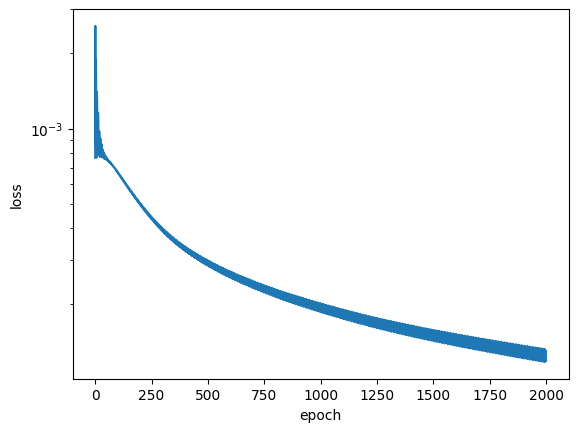

In [23]:
plt.plot(ANN_train.loss_list[0:], label="ANN with current history")
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("epoch")

(-85.0, -60.0)

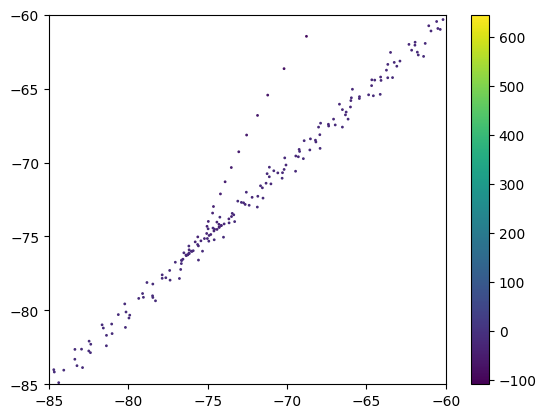

In [26]:
"""centers in the time delay space. The color represents RBFs contribution to the dynamics"""

plot_start = 0 
plot_end = -1
def get_distances_to_centers(x):
    diff = kmeans.cluster_centers_ - x
    dist = jnp.exp(-np.sum(diff**2, axis=-1)*R/2)
    return dist
dist = jax.vmap(get_distances_to_centers, in_axes=0)(kmeans.cluster_centers_)

# plt.plot(points_time_delay[:, 1], points_time_delay[:, 0], linewidth=1)
plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=(dist@w[:-2])[plot_start:plot_end], s=1)
# plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=np.clip((dist@w)[plot_start:plot_end], a_min=-30, a_max=10), s=1)
plt.colorbar()
plt.xlim(-85, -60)
plt.ylim(-85, -60)

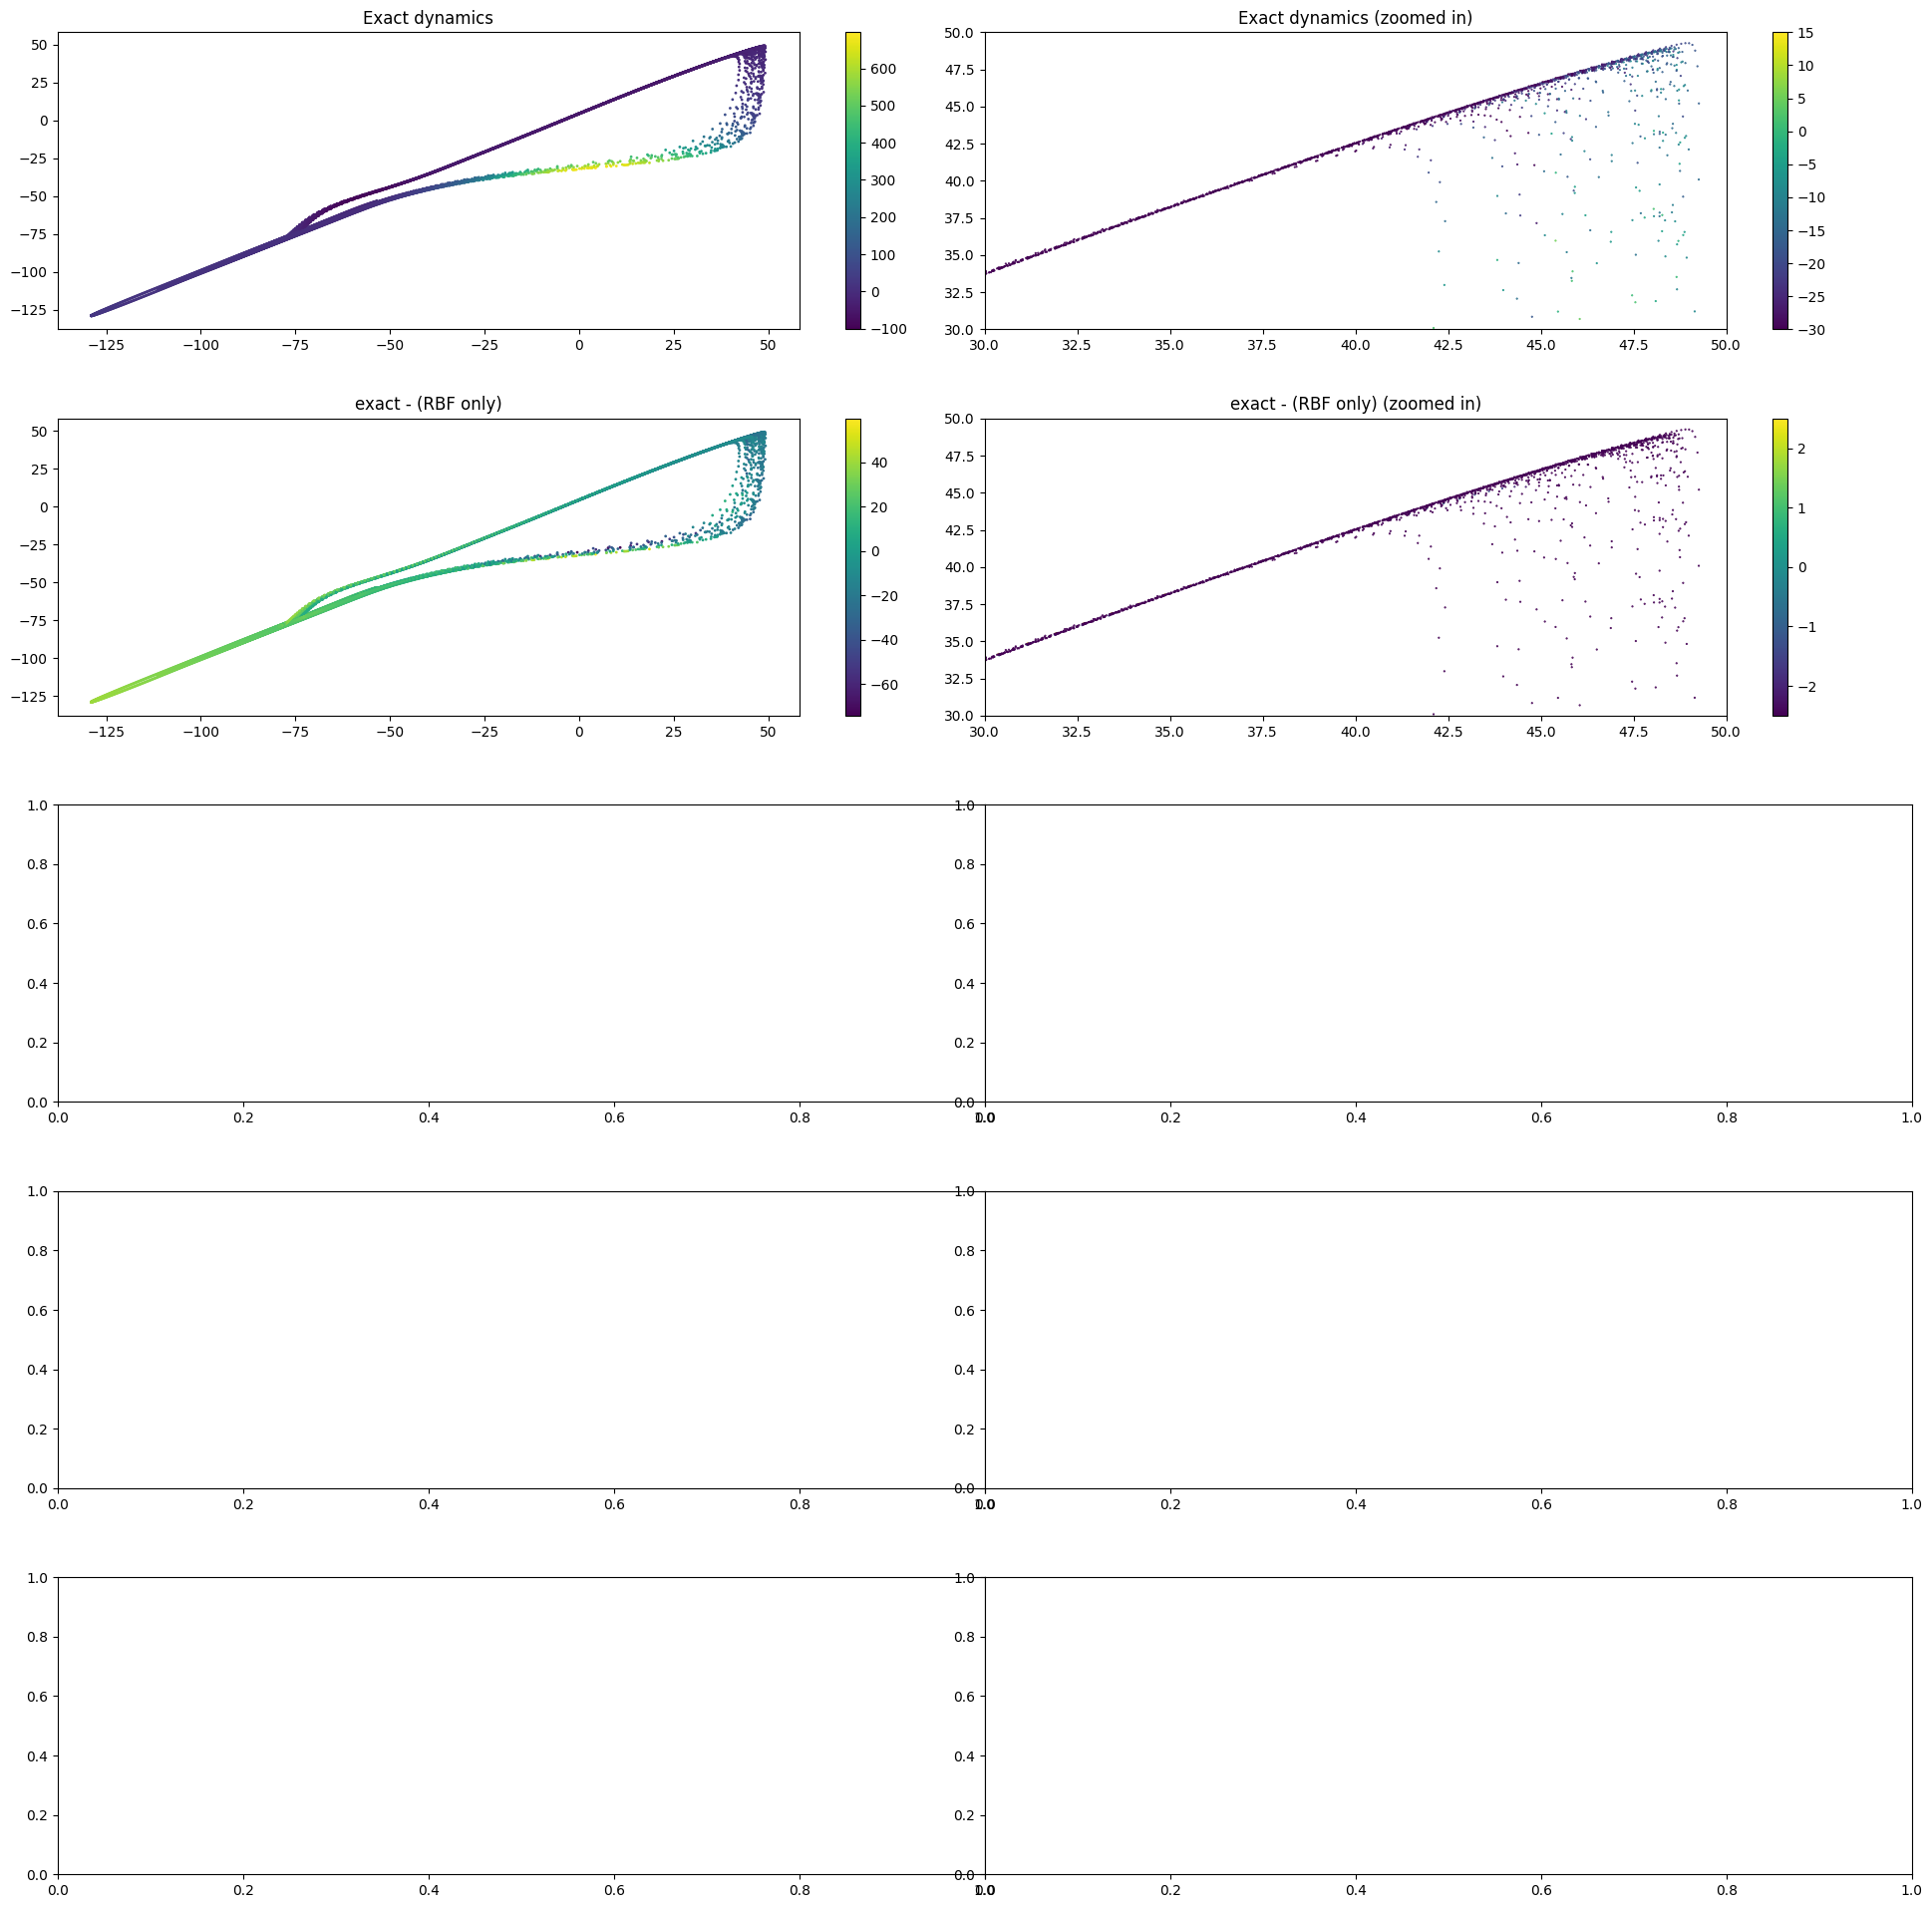

In [27]:
"""data points in the time delay space. The color represents RBFs contribution to the dynamics"""

fig, axes = plt.subplots(5, 2,  figsize=(24, 24))
fig.subplots_adjust(hspace=0.3, wspace=0.)

zoomed_x_range = (30, 50)
zoomed_y_range = (30, 50)

# Plot exact dynamics
# x = training_neuron.sol[time_delay:, 0]
# y = training_neuron.sol[:-time_delay, 0]
x = points_time_delay[:, -1]
xf = points_time_delay[:, -2]
dx = x[1:] - x[:-1]
dx[-1] = 0
# i = stimulus.stimulus_list[time_delay:]
i = stimulus.stimulus_list[time_delay*(time_delay_dim-1):]
avg_i = (i[:-1]+i[1:])/2
dx = dx/time_range[2] - avg_i
im = axes[0, 0].scatter(x[:-1], xf[:-1], c=dx[:], s=1)
axes[0, 0].set_title("Exact dynamics")
fig.colorbar(im, ax=axes[0, 0])

# Plot exact dynamics (zoomed in)
im = axes[0, 1].scatter(x[:-1], xf[:-1], c=np.clip(dx[:], a_min=-30, a_max=15), s=0.3)
axes[0, 1].set_xlim(zoomed_x_range)
axes[0, 1].set_ylim(zoomed_y_range)
axes[0, 1].set_title("Exact dynamics (zoomed in)")
fig.colorbar(im, ax=axes[0, 1])

# Plot exact - (RBF only) 
dist = jax.vmap(get_distances_to_centers, in_axes=0)(points_time_delay[:-1])
im = axes[1, 0].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=(dx - dist@w[:-2])[plot_start:plot_end], s=1)
axes[1, 0].set_title("exact - (RBF only)")
fig.colorbar(im, ax=axes[1, 0])

# Plot exact - (RBF only) (zoomed in)
im = axes[1, 1].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=np.clip((dx - dist@w[:-2])[plot_start:plot_end], a_min=-2.5, a_max=2.5), s=0.3)
axes[1, 1].set_xlim(zoomed_x_range)
axes[1, 1].set_ylim(zoomed_y_range)
axes[1, 1].set_title("exact - (RBF only) (zoomed in)")
fig.colorbar(im, ax=axes[1, 1])

# # Plot exact - (RBF+ANN)
# i_time_delay_points = np.array([np.roll(stimulus.stimulus_list[:], -i*time_delay) for i in range(time_delay_dim)]).T
# i_time_delay_points = i_time_delay_points[: -time_delay*(time_delay_dim-1)]
# avg_i_time_delay_points = (i_time_delay_points[:-1]+i_time_delay_points[1:])/2
# xyz_list = pred_model_xyz.apply(params, points_time_delay[:-1], avg_i_time_delay_points)
# im = axes[2, 0].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=((xyz_list[:, 0] + xyz_list[:, 1]*xyz_list[:, 2])/time_range[2] - dist@w)[plot_start:plot_end], s=1)
# axes[2, 0].set_title("exact - (RBF+ANN)")
# fig.colorbar(im, ax=axes[2, 0])

# # Plot exact - (RBF+ANN) (zoomed in)
# im = axes[2, 1].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=np.clip(((xyz_list[:, 0] + xyz_list[:, 1]*xyz_list[:, 2])/time_range[2] - dist@w)[plot_start:plot_end], a_min=-2.5, a_max=2.5), s=0.3)
# axes[2, 1].set_xlim(zoomed_x_range)
# axes[2, 1].set_ylim(zoomed_y_range)
# axes[2, 1].set_title("exact - (RBF+ANN) (zoomed in)")
# fig.colorbar(im, ax=axes[2, 1])


In [37]:
"""data prepartion for prediction"""
n_prediction_steps = 20000
initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1100

# training data set
initial_piece_training = training_neuron.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_training = stimulus.stimulus_list[prediction_start_after+initial_piece_len:]

# test data set
time_spacing = time_range[2]
time_range_test = (0, int((drop_first_n_points + 2*initial_piece_len + n_prediction_steps + prediction_start_after)*time_spacing)+1, time_spacing)

# ------------------ test data 1 --------------------
n_sins = 100
np.random.seed(2033)
periods_test1 = np.random.uniform(5, 50, n_sins)
coeffs_test1 = np.random.uniform(0, 1, n_sins)
phases_test1 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test1 = lib.sinusoidals_stimulus(time_range, amplitude=30, periods=periods_test1, coeffs=coeffs_test1, phases=phases_test1)

test_neuron1 = lib.single_neuron_odeint(stimulus_test1, [-10, 0, 0.8, 0.5])
test_neuron1.generate_sol()
test_neuron1.sol = test_neuron1.sol[drop_first_n_points:]
stimulus_test1.stimulus_list = stimulus_test1.stimulus_list[drop_first_n_points:]
initial_piece_test1 = test_neuron1.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test1 = stimulus_test1.stimulus_list[prediction_start_after+initial_piece_len:]

batch_initial_piece = jnp.array([initial_piece_training, initial_piece_test1])
batch_stimulus_list_len = min(len(stimulus_list_training), len(stimulus_list_test1))
batch_stimulus_list = jnp.array([stimulus_list_training[:batch_stimulus_list_len], stimulus_list_test1[:batch_stimulus_list_len]])

In [38]:
"""prediction with ann + current history"""
pred_run1_batch = lib.generate_batch_prediction_with_current(pred_model1, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
pred_run1_batch.run(params, n_steps=n_prediction_steps)
# pred_run1_batch.run(params, n_steps=6000)

100%|██████████| 20000/20000 [37:08<00:00,  8.97it/s] 


In [39]:
"""prediction without ann"""
intrinsic_model0 = rbf_only_model(time_delay_dim=time_delay_dim, R=R, centers=jnp.array(kmeans.cluster_centers_), weights=w)
pred_model0 = lib.prediction_model_with_current(intrinsic_model0, time_spacing=time_range[-1])

pred_run0_batch = lib.generate_batch_prediction_with_current(pred_model0, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
params00 = pred_model0.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.zeros((time_delay_dim)))
pred_run0_batch.run(params00, n_steps=n_prediction_steps)

100%|██████████| 20000/20000 [08:38<00:00, 38.56it/s]


Text(0, 0.5, 'current (pA)')

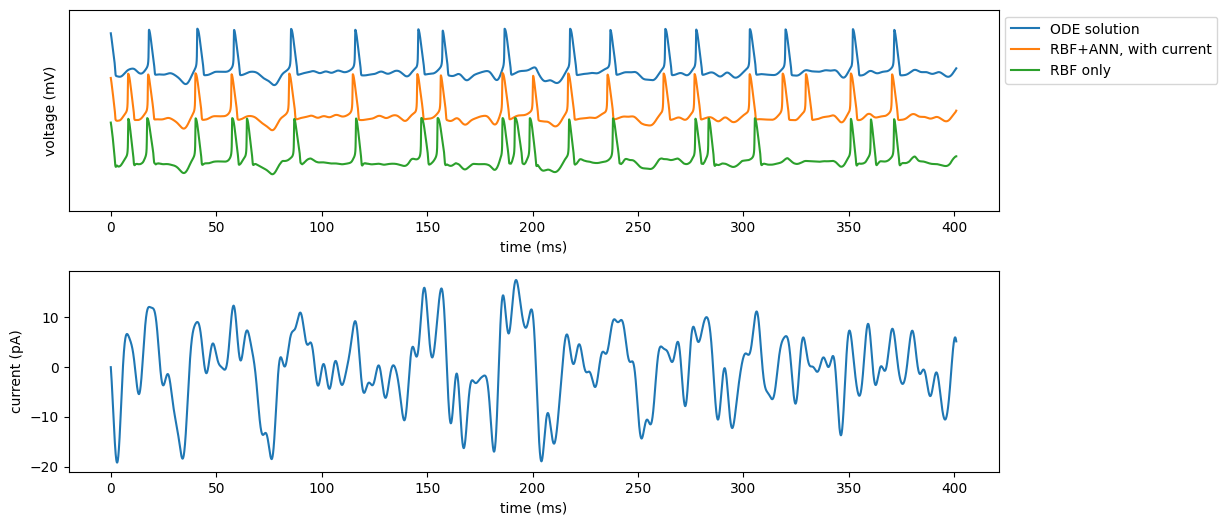

In [45]:
"""plot of prediction based on test neuron and stimulus"""
start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + n_prediction_steps

fig, axes = plt.subplots(2, 1,  figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes[0].plot(np.arange(0, (end-start)*time_spacing, time_spacing), test_neuron1.sol[prediction_start_after+start: prediction_start_after+end, 0]+0, label="ODE solution")
axes[0].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run1_batch.prediction_list[1, start:end]-120, label="RBF+ANN, with current")
axes[0].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run0_batch.prediction_list[1, start:end]-240, label="RBF only")
axes[0].set_yticks([])
axes[0].set_xlabel("time (ms)")
axes[0].set_ylabel("voltage (mV)")
axes[0].set_ylim(-440, 100)
axes[0].legend(bbox_to_anchor=(1,1))

axes[1].plot(np.arange(0, (end-start)*time_spacing, time_spacing), test_neuron1.stimulus.stimulus_list[prediction_start_after+start: prediction_start_after+end])
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("current (pA)")
# plt.plot(test_neuron.sol[start+prediction_start_after:end+prediction_start_after, 0])

Text(0, 0.5, 'current (pA)')

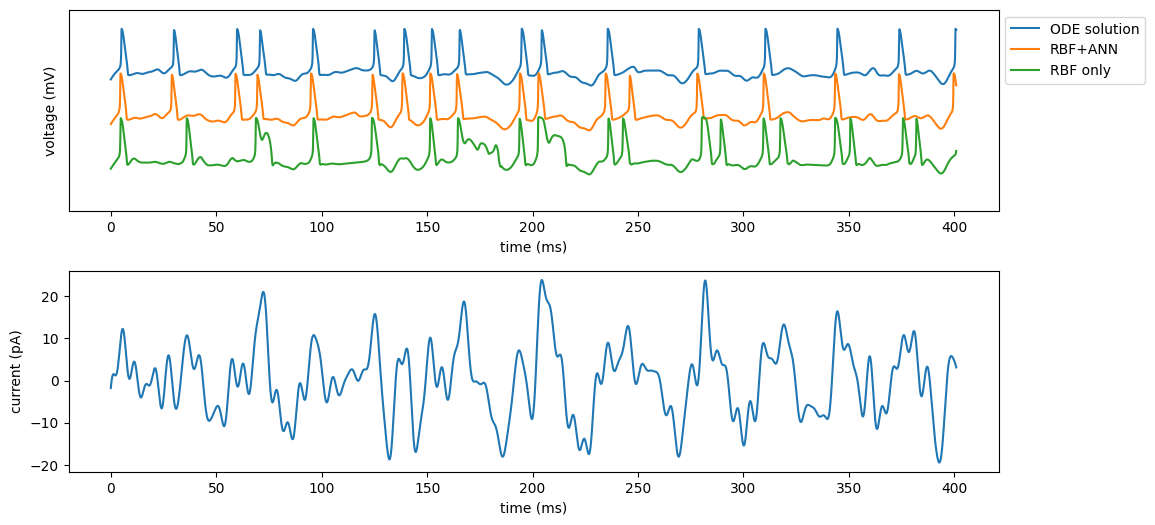

In [46]:
"""plot of prediction based on training neuron and stimulus"""
start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + 20000

fig, axes = plt.subplots(2, 1,  figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes[0].plot(np.arange(0, (end-start)*time_spacing, time_spacing), training_neuron.sol[prediction_start_after+start: prediction_start_after+end, 0]+0, label="ODE solution")
axes[0].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run1_batch.prediction_list[0, start:end]-120, label="RBF+ANN")
axes[0].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run0_batch.prediction_list[0, start:end]-240, label="RBF only")
axes[0].set_yticks([])
axes[0].set_xlabel("time (ms)")
axes[0].set_ylabel("voltage (mV)")
axes[0].set_ylim(-440, 100)
axes[0].legend(bbox_to_anchor=(1,1))

axes[1].plot(np.arange(0, (end-start)*time_spacing, time_spacing), training_neuron.stimulus.stimulus_list[prediction_start_after+start: prediction_start_after+end])
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("current (pA)")
# plt.plot(test_neuron.sol[start+prediction_start_after:end+prediction_start_after, 0])

In [68]:
"""data prepartion for prediction"""
n_prediction_steps = 20000
initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1100

# test data set
time_spacing = time_range[2]
time_range_test = (0, int((drop_first_n_points + 2*initial_piece_len + n_prediction_steps + prediction_start_after)*time_spacing)+1, time_spacing)

# ------------------ test data 1 --------------------
n_sins = 100
np.random.seed(2033)
periods_test1 = np.random.uniform(5, 50, n_sins)
coeffs_test1 = np.random.uniform(0, 1, n_sins)
phases_test1 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test1 = lib.sinusoidals_stimulus(time_range, amplitude=30, periods=periods_test1, coeffs=coeffs_test1, phases=phases_test1)

test_neuron1 = lib.single_neuron_odeint(stimulus_test1, [-10, 0, 0.8, 0.5])
test_neuron1.generate_sol()
test_neuron1.sol = test_neuron1.sol[drop_first_n_points:]
stimulus_test1.stimulus_list = stimulus_test1.stimulus_list[drop_first_n_points:]
initial_piece_test1 = test_neuron1.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test1 = stimulus_test1.stimulus_list[prediction_start_after+initial_piece_len:]

# ------------------ test data 2 --------------------
n_sins = 100
np.random.seed(0)
periods_test2 = np.random.uniform(5, 50, n_sins)
periods_test2 = periods_test2[np.argsort(np.abs(periods_test2))]
coeffs_test2 = np.random.uniform(0, 1, n_sins)
coeffs_test2 = coeffs_test2[np.argsort(np.abs(coeffs_test2))]
phases_test2 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test2 = lib.sinusoidals_stimulus(time_range, amplitude=30, periods=periods_test2, coeffs=coeffs_test2, phases=phases_test2)

test_neuron2 = lib.single_neuron_odeint(stimulus_test2, [-10, 0, 0.8, 0.5])
test_neuron2.generate_sol()
test_neuron2.sol = test_neuron2.sol[drop_first_n_points:]
stimulus_test2.stimulus_list = stimulus_test2.stimulus_list[drop_first_n_points:]
initial_piece_test2 = test_neuron2.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test2 = stimulus_test2.stimulus_list[prediction_start_after+initial_piece_len:]

# ------------------ test data 3 --------------------
n_sins = 100
np.random.seed(0)
periods_test3 = np.random.uniform(5, 50, n_sins)
periods_test3 = periods_test3[-np.argsort(np.abs(periods_test3))]
coeffs_test3 = np.random.uniform(0, 1, n_sins)
coeffs_test3 = coeffs_test3[np.argsort(np.abs(coeffs_test3))]
phases_test3 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test3 = lib.sinusoidals_stimulus(time_range, amplitude=30, periods=periods_test3, coeffs=coeffs_test3, phases=phases_test3)

test_neuron3 = lib.single_neuron_odeint(stimulus_test3, [-10, 0, 0.8, 0.5])
test_neuron3.generate_sol()
test_neuron3.sol = test_neuron3.sol[drop_first_n_points:]
stimulus_test3.stimulus_list = stimulus_test3.stimulus_list[drop_first_n_points:]
initial_piece_test3 = test_neuron3.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test3 = stimulus_test3.stimulus_list[prediction_start_after+initial_piece_len:]

# ------------------ test data 4 --------------------
stimulus_test4 = lib.lorenz1963_stimulus(time_range=time_range, initial_state=[-3.3, -3.0, 22], rescale_factor=1.5)
# stimulus_test = lib.constant_stimulus(dc_stimulus=10, time_range=time_range)
stimulus_test4.get_stimulus_list()
test_neuron4 = lib.single_neuron_odeint(stimulus_test4, [-10, 0, 0.8, 0.5])
test_neuron4.generate_sol()
test_neuron4.sol = test_neuron4.sol[drop_first_n_points:]
stimulus_test4.stimulus_list = stimulus_test4.stimulus_list[drop_first_n_points:]
initial_piece_test4 = test_neuron4.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test4 = stimulus_test4.stimulus_list[prediction_start_after+initial_piece_len:]

batch_initial_piece = jnp.array([initial_piece_test1, initial_piece_test2, initial_piece_test3, initial_piece_test4])
batch_stimulus_list_len = min(len(stimulus_list_test1), len(stimulus_list_test2), len(stimulus_list_test3), len(stimulus_list_test4))
batch_stimulus_list = jnp.array([stimulus_list_test1[:batch_stimulus_list_len], stimulus_list_test2[:batch_stimulus_list_len], stimulus_list_test3[:batch_stimulus_list_len], stimulus_list_test4[:batch_stimulus_list_len]])

In [84]:
"""prediction with ann + current history"""
pred_run1_batch = lib.generate_batch_prediction_with_current(pred_model1, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
pred_run1_batch.run(params, n_steps=40000)

100%|██████████| 40000/40000 [1:17:03<00:00,  8.65it/s]


In [86]:
"""prediction without ann"""
intrinsic_model0 = rbf_only_model(time_delay_dim=time_delay_dim, R=R, centers=jnp.array(kmeans.cluster_centers_), weights=w)
pred_model0 = lib.prediction_model_with_current(intrinsic_model0, time_spacing=time_range[-1])

pred_run0_batch = lib.generate_batch_prediction_with_current(pred_model0, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
params00 = pred_model0.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.zeros((time_delay_dim)))
pred_run0_batch.run(params00, n_steps=40000)

100%|██████████| 40000/40000 [16:18<00:00, 40.88it/s]


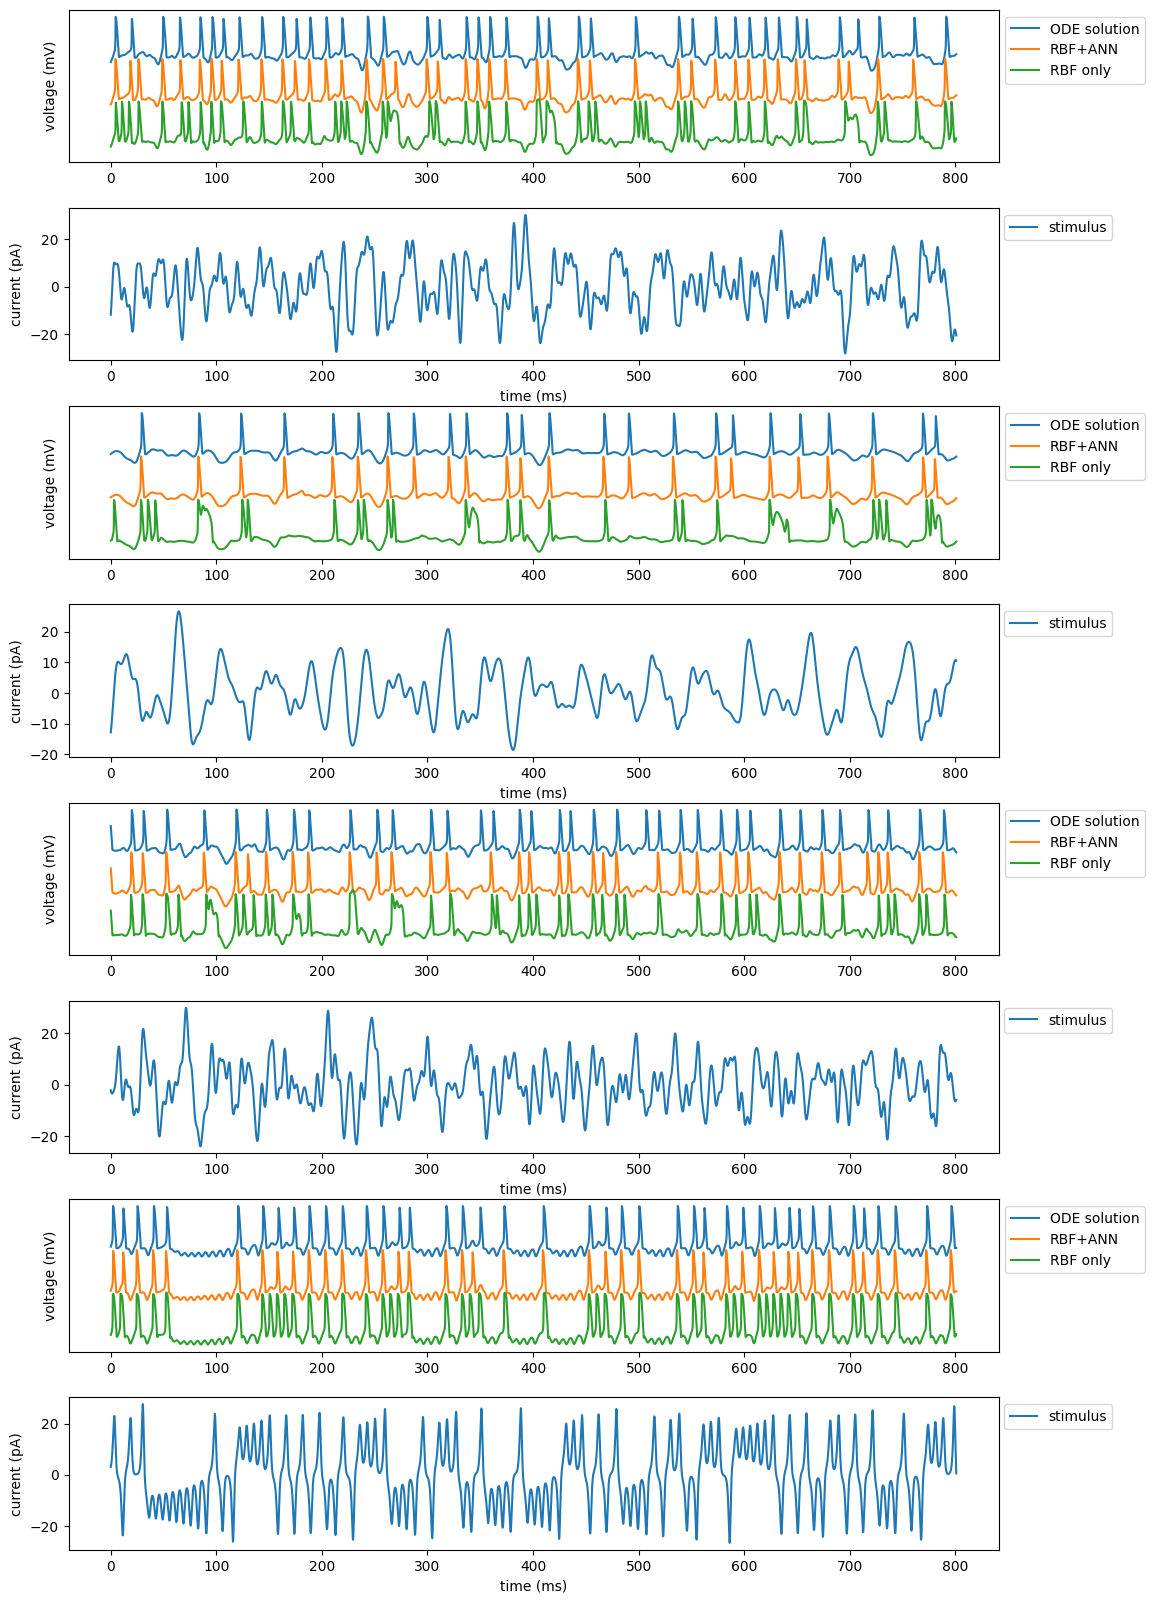

In [98]:
n_tests = 4
test_neuron_list = [test_neuron1, test_neuron2, test_neuron3, test_neuron4]

start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + 40000

fig, axes = plt.subplots(2*n_tests, 1, figsize=(12, 5*n_tests))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(n_tests):
    axes[2*i].plot(np.arange(0, (end-start)*time_spacing, time_spacing), test_neuron_list[i].sol[prediction_start_after+start: prediction_start_after+end, 0]+0, label="ODE solution")
    axes[2*i].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run1_batch.prediction_list[i, start:end]-130, label="RBF+ANN")
    axes[2*i].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run0_batch.prediction_list[i, start:end]-260, label="RBF only")
    axes[2*i].set_yticks([])
    axes[2*i].set_ylabel("voltage (mV)")
    # axes[2*i].set_ylim(-440, 100)
    axes[2*i].legend(bbox_to_anchor=(1,1))
    
    axes[2*i+1].plot(np.arange(0, (end-start)*time_spacing, time_spacing), batch_stimulus_list[i, prediction_start_after+start: prediction_start_after+end], label="stimulus")
    axes[2*i+1].set_xlabel("time (ms)")
    axes[2*i+1].set_ylabel("current (pA)")
    axes[2*i+1].legend(bbox_to_anchor=(1.13,1))